# Fraud Detection

* [Reading Data](#1)
* [Histograms](#2)
* [Correlations](#3)
* [WoE](#4)
* [Outliers](#5)
* [Features with Low Variance](#6)
* [PCA](#7)
* [Modeling](#8)
* [GridSearch](#9)
* [Conclusion](#10)

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, ks_2samp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from collections import Counter

pd.set_option('chained_assignment',None)

### Reading Data <a class="anchor" id="1"></a>

In [2]:
df = pd.read_csv('desafio_fraude.csv')

print(df.shape)
df.head()

(150000, 31)


,Ocorrencia,PP1,PP2,PP3,PP4,PP5,PP6,PP7,PP8,PP9,...,PP21,PP22,PP23,PP24,PP25,PP26,PP27,PP28,Sacado,Fraude
0,-44299.0,-1.239996,0.985194,-1.005080,0.251323,0.872854,-1.677811,1.451311,-0.478908,-0.009459,...,0.387768,0.286200,0.128686,1.280392,-0.301116,-0.673309,-0.069611,-0.009597,-28.38,0
1,-44300.0,-0.472690,1.869177,-0.277741,1.122846,1.526166,0.262325,0.242333,-0.006108,-1.659659,...,-0.387745,-0.434629,0.512801,-0.110994,-0.350975,-0.073826,0.035071,-0.080140,-407.00,0
2,-44301.0,0.277314,3.455314,-0.722444,-0.428284,2.512025,-0.540760,0.345111,-0.013655,-0.233508,...,-0.630255,-0.388096,0.697177,-0.523084,-0.069830,0.196482,0.052145,-0.166683,-800.00,0
3,-44301.0,-1.061770,-0.105481,-0.226711,-0.929524,-0.100625,-0.300173,0.029912,-0.205934,0.233190,...,-0.147422,-0.426827,0.070413,0.283090,-0.487739,0.288220,-0.035644,-0.007305,-31.28,0
4,-44302.0,4.622715,2.621667,0.872085,0.374010,1.456021,-1.531875,-0.162837,-1.331547,-0.340639,...,0.221196,0.804017,1.309062,1.505088,0.260178,-0.861611,-0.130562,1.023781,-522.16,0


#### Quick Check

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
Ocorrencia    150000 non-null float64
PP1           150000 non-null float64
PP2           150000 non-null float64
PP3           150000 non-null float64
PP4           150000 non-null float64
PP5           150000 non-null float64
PP6           150000 non-null float64
PP7           150000 non-null float64
PP8           150000 non-null float64
PP9           150000 non-null float64
PP10          150000 non-null float64
PP11          150000 non-null float64
PP12          150000 non-null float64
PP13          150000 non-null float64
PP14          150000 non-null float64
PP15          150000 non-null float64
PP16          150000 non-null float64
PP17          150000 non-null float64
PP18          150000 non-null float64
PP19          150000 non-null float64
PP20          150000 non-null float64
PP21          150000 non-null float64
PP22          150000 non-null float64
PP23          1

There are no null-values and all variables are continuous. Just to make sure:

In [4]:
[(col, df[col].isna().sum()) for col in df.columns]

[('Ocorrencia', 0),
 ('PP1', 0),
 ('PP2', 0),
 ('PP3', 0),
 ('PP4', 0),
 ('PP5', 0),
 ('PP6', 0),
 ('PP7', 0),
 ('PP8', 0),
 ('PP9', 0),
 ('PP10', 0),
 ('PP11', 0),
 ('PP12', 0),
 ('PP13', 0),
 ('PP14', 0),
 ('PP15', 0),
 ('PP16', 0),
 ('PP17', 0),
 ('PP18', 0),
 ('PP19', 0),
 ('PP20', 0),
 ('PP21', 0),
 ('PP22', 0),
 ('PP23', 0),
 ('PP24', 0),
 ('PP25', 0),
 ('PP26', 0),
 ('PP27', 0),
 ('PP28', 0),
 ('Sacado', 0),
 ('Fraude', 0)]

Really no null-values. One less headache! 

In [5]:
df.describe()

,Ocorrencia,PP1,PP2,PP3,PP4,PP5,PP6,PP7,PP8,PP9,...,PP21,PP22,PP23,PP24,PP25,PP26,PP27,PP28,Sacado,Fraude
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,-84550.214580,0.058999,-0.000790,-0.192183,-0.037416,0.061588,-0.025715,0.026695,-0.004257,0.028148,...,0.009957,0.027398,0.007275,-0.002739,-0.035211,-0.001127,-0.000535,-0.001028,-88.602261,0.001580
std,27710.748503,1.894453,1.623712,1.406053,1.397615,1.341265,1.310820,1.194923,1.205874,1.106154,...,0.739429,0.707714,0.622620,0.606964,0.506130,0.483787,0.397662,0.307684,247.302373,0.039718
min,-133236.000000,-2.454930,-22.057729,-9.382558,-16.875344,-32.911462,-21.307738,-31.527244,-16.635979,-15.594995,...,-27.202839,-10.503090,-19.002942,-4.022866,-7.519589,-3.220178,-12.152401,-22.620072,-19656.530000,0.000000
25%,-115169.000000,-1.243456,-0.802149,-1.138473,-0.812624,-0.526469,-0.424574,-0.527260,-0.340863,-0.565387,...,-0.165038,-0.466423,-0.128298,-0.431560,-0.369398,-0.247606,-0.090965,-0.078861,-77.662500,0.000000
50%,-77502.500000,0.042647,-0.082193,-0.359076,-0.039549,0.124219,0.245177,-0.013129,-0.037083,0.095975,...,0.033794,0.014600,0.020008,-0.049357,-0.071030,0.057265,-0.004792,-0.016759,-22.040000,0.000000
75%,-61713.750000,0.952018,0.588600,0.555060,0.816575,0.751890,0.734024,0.564334,0.193112,0.678488,...,0.225362,0.540801,0.164620,0.348762,0.274183,0.331361,0.068544,0.048427,-5.410000,0.000000
max,-44299.000000,36.802320,63.344698,33.680984,5.683171,31.356750,21.929312,43.557242,73.216718,13.434066,...,34.830382,10.933144,44.807735,2.824849,10.295397,2.604551,22.565679,11.710896,-0.000000,1.000000


Well, variables have different ranges and deviations. Maybe will need to feature scale later.

Let's look at the target.

In [6]:
df['Fraude'].value_counts(normalize=True)

0    0.99842
1    0.00158
Name: Fraude, dtype: float64

Indeed, it is an **unbalanced** problem, given that only about 0.1% of the records are frauds.

### Histograms <a class="anchor" id="2"></a>

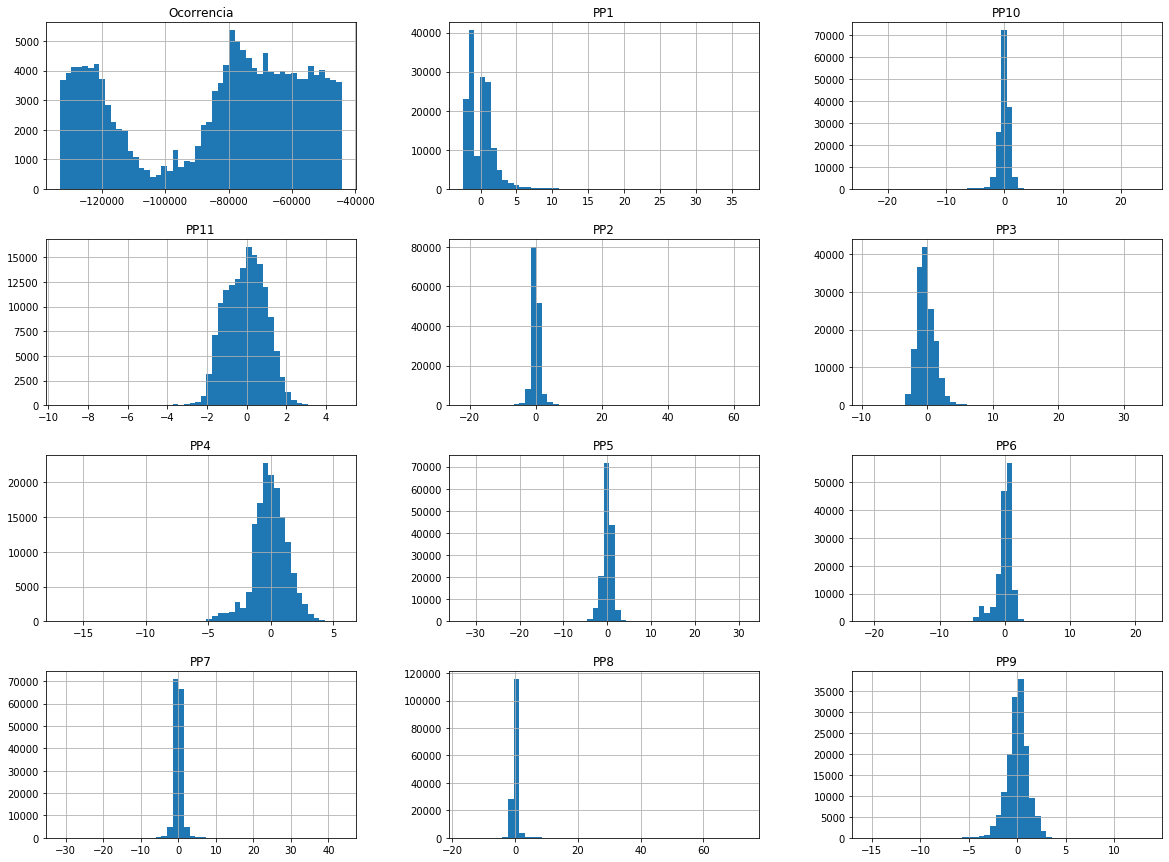

In [7]:
df.iloc[:,0:12].hist(bins=50, figsize=(20,15))
plt.show()

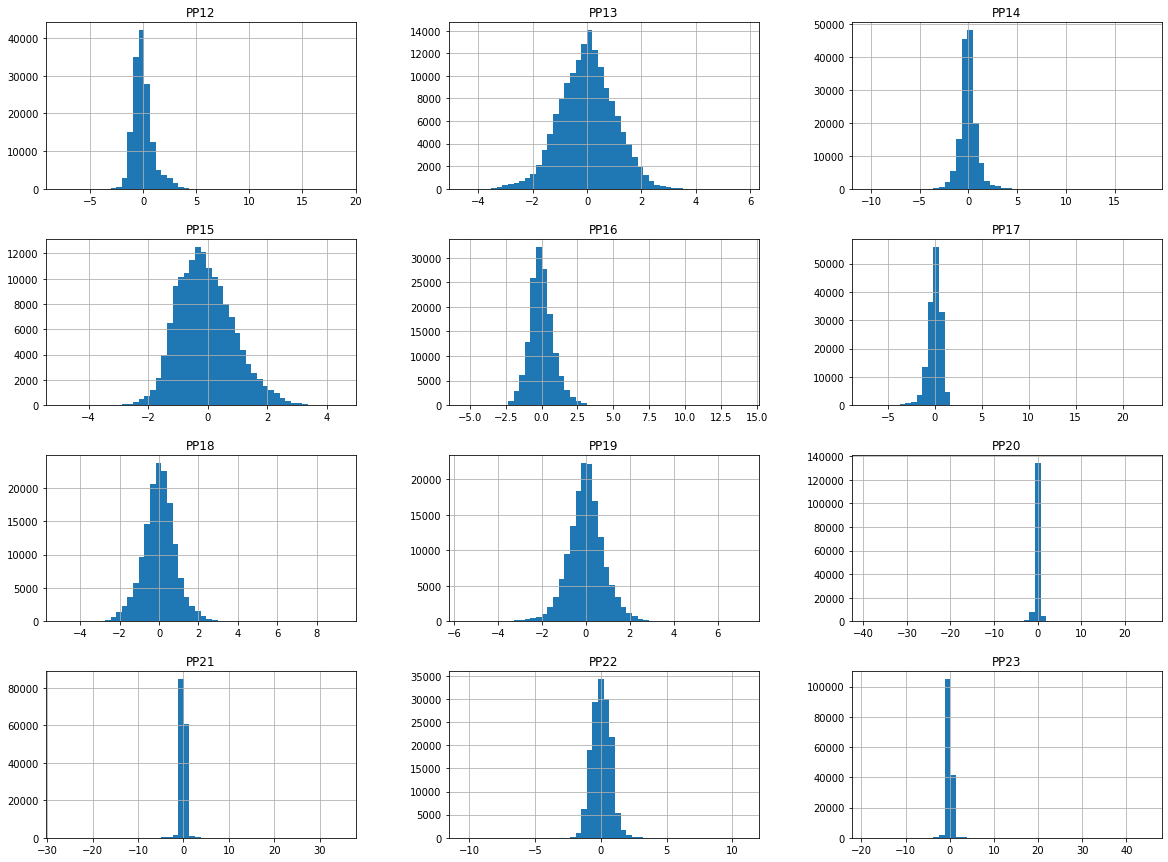

In [8]:
df.iloc[:,12:24].hist(bins=50, figsize=(20,15))
plt.show()

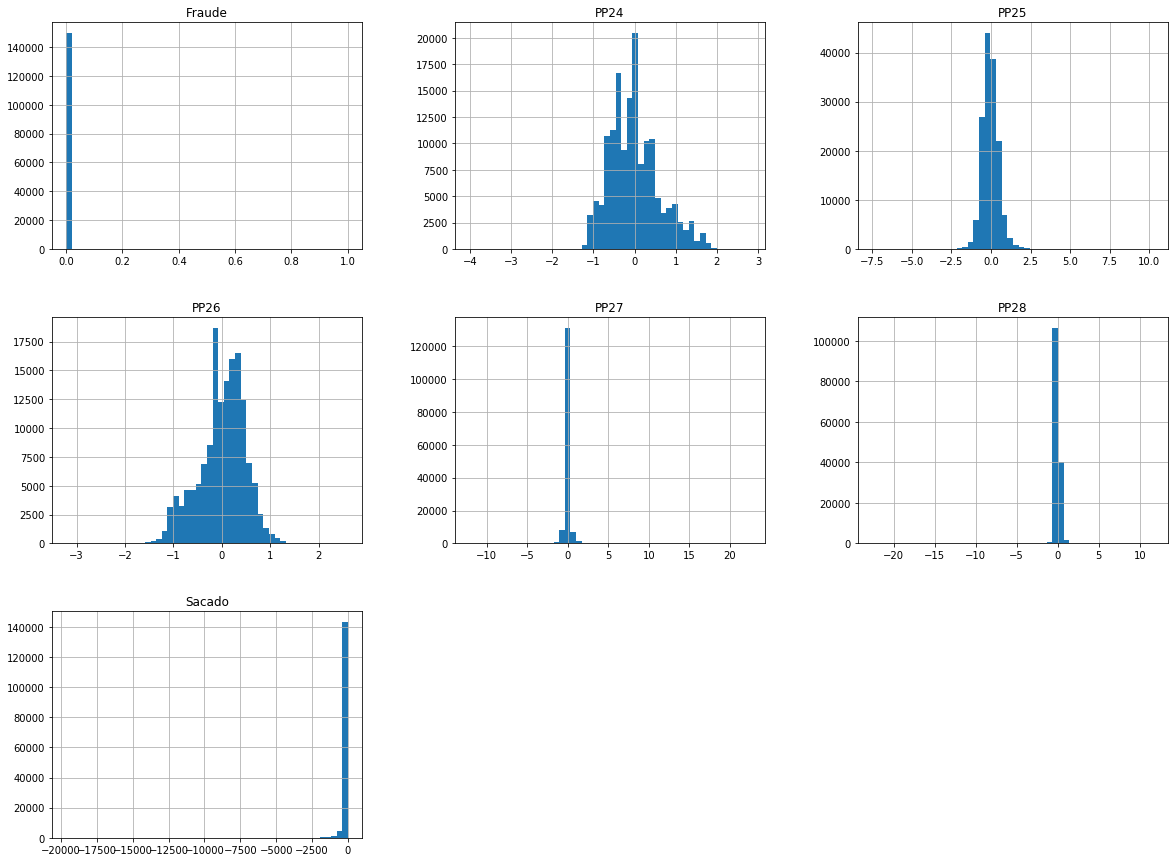

In [9]:
df.iloc[:,24:].hist(bins=50, figsize=(20,15))
plt.show()

Most of the features are nicely normally distributed, but some seem to have too little variance (like PP7, PP8, PP20, PP21, PP23, PP27 and PP28).  

Will just adjust PP1 to better separate the two groups (using Cubic Root transformation).

#### Adjusting PP1 with Cubic Root

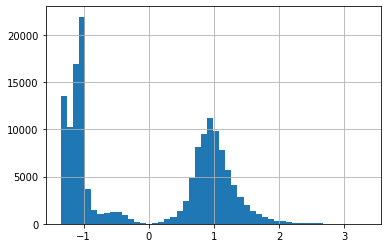

In [10]:
df['PP1'] = np.cbrt(df['PP1'])

df['PP1'].hist(bins=50)
plt.show()

Now the variable bimodal behavior is better separated and outlier effect is diminished.

### Correlations <a class="anchor" id="3"></a>

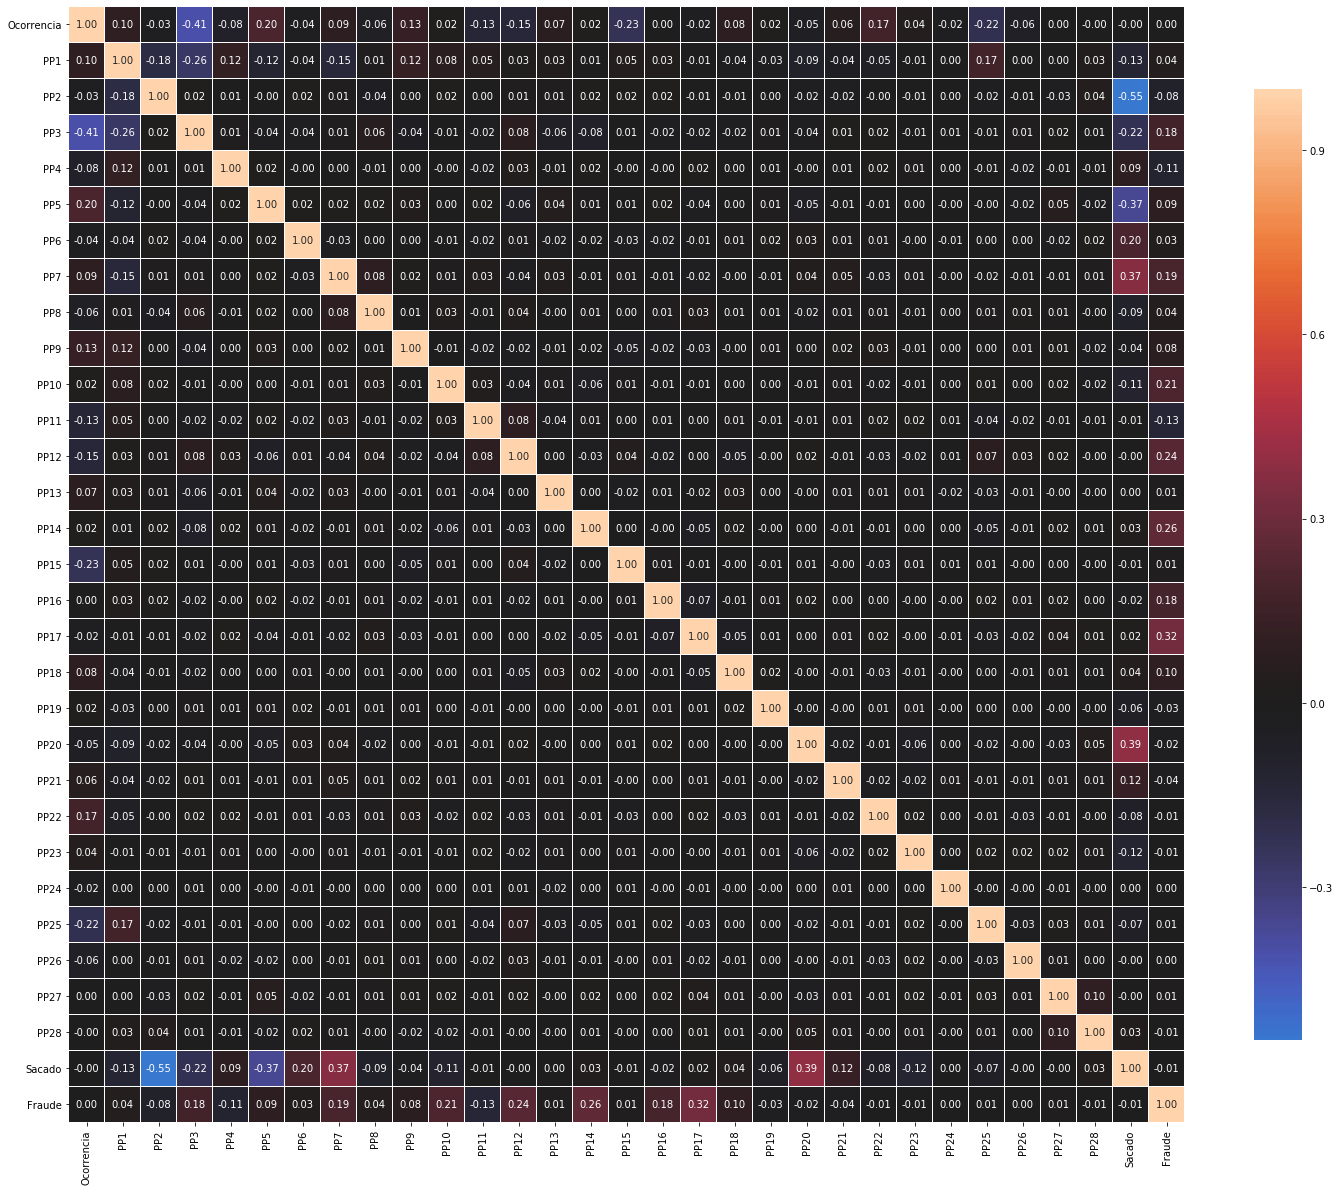

In [11]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(25,25))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show()
    
correlation_heatmap(df)

Most of the features have insignificant correlations. Most notable are PP3/Ocorrencia and Sacado with other 4 varibles, the highest being -0.55 with PP2 (although this value does not imply very high correlation). Given that, I have decided to not exclude any variable based on correlation. PP17, PP14, PP12 and PP10 have the highest correlation with the target variable. Keep those features in mind.

### WoE <a class="anchor" id="4"></a>

To conduct WoE (Weight Of Evidence), one must first categorize numerical variables. Will do that binning every variable in 3 buckets with equal number of observations, using pandas *qcut* function. 

In [12]:
features = [col for col in df if col != 'Fraude']

df_woe = df.copy()
for col in df_woe[features].columns:
    df_woe[col] = pd.qcut(df_woe[col], 3, labels=False)
    
df_woe.head()

,Ocorrencia,PP1,PP2,PP3,PP4,PP5,PP6,PP7,PP8,PP9,...,PP21,PP22,PP23,PP24,PP25,PP26,PP27,PP28,Sacado,Fraude
0,2,0,2,0,1,2,0,2,0,1,...,2,1,2,2,0,0,0,1,1,0
1,2,1,2,1,2,2,1,1,1,0,...,0,0,2,1,0,1,1,0,0,0
2,2,1,2,1,1,2,0,1,1,1,...,0,0,2,0,1,1,2,0,0,0
3,2,1,1,1,0,1,0,1,1,1,...,0,0,1,2,0,2,1,1,1,0
4,2,2,2,2,1,2,0,1,0,0,...,2,2,2,2,2,0,0,2,0,0


#### Defining WoE function

In [13]:
def woe_total(df, feature, target, plot=True):
    '''
    Calculate WoE (Weight of Evidence) for given feature
    considering all dataset 
    
    Pass dataframe and categorized feature
    Return WoE dataframe if plot=False, 
    otherwise return plot
    '''
    woe_df = df[[feature, target]]
    
    totals = woe_df.groupby([feature]).count().reset_index()
    
    totals['Events'] = woe_df.groupby([feature]).sum().reset_index()[target]
    totals['Non-Events'] = totals[target] - totals['Events'] 

    totals['%Events'] = totals['Events']/(totals['Events']+totals['Non-Events'])
    totals['%Non-Events'] = totals['Non-Events']/(totals['Events']+
                                                                      totals['Non-Events'])
    totals['WoE'] = np.log(totals['%Events']/totals['%Non-Events'])

    if plot:
        categories = np.unique(woe_df.iloc[:,0])
        fig, ax = plt.subplots(figsize=(8,4))

        for i, cat in enumerate(categories):
            markers = ['o', 'v', 's', '*', 'D', 'P', 'X', '^']
            ax.scatter(i, totals.loc[totals[feature] == cat, 'WoE'], label=cat, s=200, marker=markers[i])
            ax.legend()
        ax.set_xticklabels([''])
        ax.axhline(0, color='red')
        ax.set_title('WoE Total - {}'.format(feature))
        ax.set_ylabel('WoE')
    else:
        return totals 

In [14]:
woe_total(df_woe, 'PP2', 'Fraude', False)

,PP2,Fraude,Events,Non-Events,%Events,%Non-Events,WoE
0,0,50000,197,49803,0.00394,0.99606,-5.532627
1,1,50007,16,49991,0.00032,0.99968,-8.047010
2,2,49993,24,49969,0.00048,0.99952,-7.641104


For this variable, we can see that the first bucket has 10 times more Frauds than the other 2 buckets. This type of analysis can be useful when one has knowledge about variables. Since the dataframe given was anonymized, I will not go further with WoE.

### Outliers <a class="anchor" id="5"></a>

Since most of the variables are normally distributed, a good way to detect Outliers is to use the Z-Score. Let's compute them and put it in a separate dataframe.

In [15]:
df_zscore = df.copy()

df_zscore[features] = df_zscore[features].apply(zscore)

df_zscore

,Ocorrencia,PP1,PP2,PP3,PP4,PP5,PP6,PP7,PP8,PP9,...,PP21,PP22,PP23,PP24,PP25,PP26,PP27,PP28,Sacado,Fraude
0,1.452554,-0.985401,0.607243,-0.578142,0.206595,0.604854,-1.260358,1.192228,-0.393617,-0.033998,...,0.510952,0.365689,0.195001,2.114023,-0.525371,-1.389421,-0.173706,-0.027852,0.243518,0
1,1.452518,-0.711537,1.151666,-0.060850,0.830176,1.091942,0.219741,0.180462,-0.001535,-1.525840,...,-0.537851,-0.652846,0.811936,-0.178356,-0.623881,-0.150271,0.089540,-0.257123,-1.287488,0
2,1.452481,0.615415,2.128527,-0.377129,-0.279669,1.826966,-0.392920,0.266475,-0.007794,-0.236547,...,-0.865822,-0.587094,1.108066,-0.857295,-0.068399,0.408465,0.132474,-0.538396,-2.876641,0
3,1.452481,-0.935186,-0.064476,-0.024557,-0.638310,-0.120940,-0.209379,0.002692,-0.167246,0.185366,...,-0.212839,-0.641821,0.101408,0.470917,-0.894097,0.598090,-0.088287,-0.020401,0.231791,0
4,1.452445,1.555368,1.615105,0.756921,0.294379,1.039644,-1.149025,-0.158615,-1.100691,-0.333398,...,0.285680,1.097367,2.090826,2.484221,0.583625,-1.778647,-0.326980,3.330732,-1.753154,0
5,1.452445,-0.981881,-0.034877,-0.322386,-0.838697,0.332925,0.196228,0.192049,-0.057406,-0.753223,...,0.516861,1.400395,-0.121911,0.317786,-0.708302,1.250213,-0.097305,-0.074044,0.349097,0
6,1.452445,-0.971023,-0.174094,0.022727,-0.596579,-0.163207,0.004658,-0.057781,-0.047207,0.239018,...,-0.129952,-0.481487,0.185340,0.481784,-1.189520,0.614738,-0.069092,-0.007839,0.352211,0
7,1.452445,1.422906,2.943124,-0.502896,0.271327,-2.055703,0.641306,1.064781,-0.404160,1.005183,...,-0.333678,0.649857,-2.266220,2.286027,0.180772,-0.699595,0.306683,-0.735704,-1.198487,0
8,1.452445,-0.994214,0.265920,-0.129913,1.049748,0.553487,0.475634,0.293952,-0.014615,-1.404025,...,0.426987,0.975534,-0.086998,-0.036538,-0.642520,0.584208,-0.051309,-0.015922,0.353666,0
9,1.452409,0.893312,0.262019,-0.938725,1.166103,0.781218,0.405424,-0.717286,0.049532,1.476413,...,-0.036519,-0.132637,-0.447360,-0.906489,0.154585,-2.006428,0.161230,-0.315946,-0.464282,0


#### Records with |z| >= 3

In [16]:
totals = []
length = len(df_zscore)

for col in df_zscore[features]:
    totals.append(df_zscore[col].apply(lambda x: 1 if abs(x) >=3 else 0).sum())
    
outlier_pct = [(x/length)*100 for x in totals]

df_out = pd.DataFrame({'# of Outliers': totals, '% of Outliers': outlier_pct}, index=features)

df_out.sort_values(by='% of Outliers', ascending=False)

,# of Outliers,% of Outliers
PP6,2634,1.756000
PP27,2563,1.708667
PP20,2527,1.684667
PP2,2298,1.532000
Sacado,2243,1.495333
PP21,2193,1.462000
PP8,2174,1.449333
PP14,2138,1.425333
PP28,2031,1.354000
PP12,1906,1.270667


The variable with the most outliers has ~1.7% of records more than 3 standard deviations away from the mean. Many variables have less than 1% of such cases. Let's check the Fraud distribution for those outliers, in order to find out if they contribute or are just noise.

In [17]:
df_zscore.loc[abs(df_zscore['Sacado']) >= 3, 'Fraude'].value_counts(normalize=True)

0    0.997771
1    0.002229
Name: Fraude, dtype: float64

In [18]:
df_zscore.loc[abs(df_zscore['PP11']) >= 3, 'Fraude'].value_counts(normalize=True)

0    0.609907
1    0.390093
Name: Fraude, dtype: float64

In [19]:
df_zscore.loc[abs(df_zscore['PP3']) >= 3, 'Fraude'].value_counts(normalize=True)

0    0.88817
1    0.11183
Name: Fraude, dtype: float64

There are mixed results. For Sacado the distribution is basically the same as the whole dataframe, while PP3 and PP11 have many outliers that are indeed fraudsters.

#### Checking Outlier's Fraud Frequencies

In [20]:
fraud_outlier_frequencies = []

for col in df_zscore[features]:
    freqs = df_zscore.loc[abs(df_zscore[col]) >= 3, 'Fraude'].value_counts(normalize=True)
    if len(freqs) > 1:
        freqs = freqs[1]
    else:
        freqs = 0
    fraud_outlier_frequencies.append(freqs*100)
        
df_out_freq = pd.DataFrame({'Fraud Frequency': fraud_outlier_frequencies}, index=features)

df_out_freq.sort_values(by='Fraud Frequency', ascending=False)

,Fraud Frequency
PP11,39.009288
PP16,12.611807
PP17,11.738294
PP18,11.199095
PP3,11.182994
PP14,8.840037
PP12,8.761805
PP10,8.220660
PP4,5.959398
PP7,5.869565


Three variables (PP24, PP1 and Ocorrencia) have not even a single Fraudster in their Outliers, meaning it is just noise. In those cases, we will substitute the outliers by the mean.

#### Substitute Outliers by the Mean

In [21]:
outliers_to_impute = ['PP1', 'PP24']

for out in outliers_to_impute:
    out_index = list(df_zscore.loc[df_zscore[out] >= 3].index) #indexes to be imputed
    mean_val  = df[out].mean() # mean value will substitute outliers
    df.loc[out_index, out] = mean_val

### Features with Low Variance <a class="anchor" id="6"></a>

Next, let's take a look at the variance of each feature, to see if there are variables carrying little information. But first all features must be on the same scale - that's why Min Max Scaling will be conducted (bringing everybody to the range [0,1]).

#### Min Max Scaling

In [22]:
df_scaled = df[features].copy()
scaler = MinMaxScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=features)

df_scaled

,Ocorrencia,PP1,PP2,PP3,PP4,PP5,PP6,PP7,PP8,PP9,...,PP20,PP21,PP22,PP23,PP24,PP25,PP26,PP27,PP28,Sacado
0,1.000000,0.060108,0.269816,0.194538,0.759211,0.525677,0.454007,0.439219,0.179817,0.536894,...,0.615605,0.444771,0.503320,0.299819,0.908043,0.405191,0.437251,0.348026,0.658603,0.998556
1,0.999989,0.124743,0.280167,0.211427,0.797845,0.535842,0.498879,0.423118,0.185079,0.480048,...,0.598063,0.432270,0.469694,0.305838,0.669805,0.402392,0.540172,0.351041,0.656548,0.979294
2,0.999978,0.437922,0.298739,0.201101,0.729084,0.551182,0.480305,0.424487,0.184995,0.529176,...,0.583944,0.428361,0.471864,0.308728,0.599245,0.418174,0.586579,0.351533,0.654027,0.959301
3,0.999978,0.071959,0.257045,0.212612,0.706865,0.510530,0.485870,0.420289,0.182855,0.545253,...,0.612383,0.436144,0.470058,0.298905,0.737281,0.394715,0.602328,0.349004,0.658670,0.998409
4,0.999966,0.659764,0.288978,0.238128,0.764649,0.534751,0.457382,0.417722,0.170328,0.525486,...,0.621350,0.442086,0.527476,0.318317,0.946516,0.436698,0.404923,0.346270,0.688703,0.973436
5,0.999966,0.060939,0.257608,0.202888,0.694450,0.520002,0.498166,0.423302,0.184329,0.509488,...,0.613390,0.444842,0.537481,0.296726,0.721367,0.399994,0.656492,0.348901,0.658189,0.999885
6,0.999966,0.063501,0.254961,0.214156,0.709450,0.509648,0.492359,0.419326,0.184466,0.547298,...,0.612069,0.437132,0.475351,0.299724,0.738411,0.386322,0.603711,0.349224,0.658782,0.999924
7,0.999966,0.628501,0.314227,0.196994,0.763221,0.470152,0.511660,0.437191,0.179676,0.576492,...,0.589196,0.434704,0.512702,0.275804,0.925919,0.425253,0.494546,0.353528,0.652259,0.980414
8,0.999966,0.058028,0.263326,0.209173,0.811448,0.524605,0.506637,0.424924,0.184904,0.484689,...,0.611292,0.443771,0.523454,0.297067,0.684544,0.401863,0.601175,0.349428,0.658710,0.999942
9,0.999955,0.503509,0.263252,0.182764,0.818657,0.529358,0.504508,0.408831,0.185765,0.594448,...,0.610703,0.438246,0.486868,0.293551,0.594133,0.424509,0.386004,0.351862,0.656021,0.989651


#### Variances

In [23]:
selector = VarianceThreshold()

selector.fit(df_scaled)

df_var = pd.DataFrame({'Variance (Scaled)': selector.variances_}, index=features)

df_var.sort_values(by='Variance (Scaled)')

,Variance (Scaled)
PP28,0.000080
PP23,0.000095
PP27,0.000131
PP20,0.000139
PP21,0.000142
Sacado,0.000158
PP8,0.000180
PP7,0.000253
PP2,0.000361
PP5,0.000436


PP23, PP28 and PP27 have the least variance and (looking at the correlations heatmap) no correlation to the Target - will drop those features. PP20 has correlation with Sacado, so I will leave it.

#### Remove Features

In [24]:
df.drop(['PP23', 'PP28', 'PP27'], axis=1, inplace=True)

features = [col for col in df if col != 'Fraude']

### PCA <a class="anchor" id="7"></a>

For PCA, we need to first scale the data with Standardization (mean=0 and variance=1).

In [25]:
df_scaled = df.copy()
scaler = StandardScaler()

df_scaled[features] = pd.DataFrame(scaler.fit_transform(df_scaled[features]), columns=features)

df_scaled

,Ocorrencia,PP1,PP2,PP3,PP4,PP5,PP6,PP7,PP8,PP9,...,PP18,PP19,PP20,PP21,PP22,PP24,PP25,PP26,Sacado,Fraude
0,1.452554,-0.985473,0.607243,-0.578142,0.206595,0.604854,-1.260358,1.192228,-0.393617,-0.033998,...,-1.785697,0.216948,0.503995,0.510952,0.365689,2.141398,-0.525371,-1.389421,0.243518,0
1,1.452518,-0.711549,1.151666,-0.060850,0.830176,1.091942,0.219741,0.180462,-0.001535,-1.525840,...,-1.085263,-1.182226,-0.984745,-0.537851,-0.652846,-0.174406,-0.623881,-0.150271,-1.287488,0
2,1.452481,0.615691,2.128527,-0.377129,-0.279669,1.826966,-0.392920,0.266475,-0.007794,-0.236547,...,2.331057,-0.279733,-2.183033,-0.865822,-0.587094,-0.860282,-0.068399,0.408465,-2.876641,0
3,1.452481,-0.935247,-0.064476,-0.024557,-0.638310,-0.120940,-0.209379,0.002692,-0.167246,0.185366,...,0.600185,0.981217,0.230558,-0.212839,-0.641821,0.481502,-0.894097,0.598090,0.231791,0
4,1.452445,1.555849,1.615105,0.756921,0.294379,1.039644,-1.149025,-0.158615,-1.100691,-0.333398,...,-0.319784,-0.443985,0.991586,0.285680,1.097367,2.515379,0.583625,-1.778647,-1.753154,0
5,1.452445,-0.981952,-0.034877,-0.322386,-0.838697,0.332925,0.196228,0.192049,-0.057406,-0.753223,...,0.265489,-0.316328,0.316037,0.516861,1.400395,0.326806,-0.708302,1.250213,0.349097,0
6,1.452445,-0.971092,-0.174094,0.022727,-0.596579,-0.163207,0.004658,-0.057781,-0.047207,0.239018,...,0.013302,0.376667,0.203881,-0.129952,-0.481487,0.492480,-1.189520,0.614738,0.352211,0
7,1.452445,1.423358,2.943124,-0.502896,0.271327,-2.055703,0.641306,1.064781,-0.404160,1.005183,...,-2.141295,1.232680,-1.737285,-0.333678,0.649857,2.315159,0.180772,-0.699595,-1.198487,0
8,1.452445,-0.994288,0.265920,-0.129913,1.049748,0.553487,0.475634,0.293952,-0.014615,-1.404025,...,-0.079015,-1.945638,0.137952,0.426987,0.975534,-0.031139,-0.642520,0.584208,0.353666,0
9,1.452409,0.893649,0.262019,-0.938725,1.166103,0.781218,0.405424,-0.717286,0.049532,1.476413,...,-2.134925,1.511254,0.087955,-0.036519,-0.132637,-0.909979,0.154585,-2.006428,-0.464282,0


#### PCA Explained Variance Cumsum

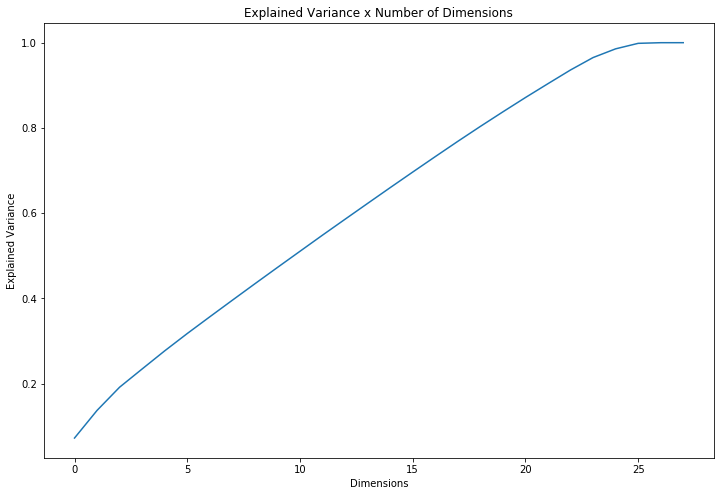

In [26]:
pca = PCA()
pca.fit(df_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(12,8))

ax.set_title('Explained Variance x Number of Dimensions')
ax.set_xlabel('Dimensions')
ax.set_ylabel('Explained Variance')
plt.plot(range(len(cumsum)), cumsum)

plt.show()

PCA is not able to retain much variance with few features (above 80% with 20 dimensions), so, it is not useful for this dataset and will not be used. 

## Modeling <a class="anchor" id="8"></a>

For modeling, I will adopt a stratified 70/30 split and compare Random Forest, Naive Bayes, Logistic Regression and SVM on the Standardized dataset (required for SVM and LR, not necessary for RF and NB). Since it is a Fraud detection problem, the focus will be on **Recall**, since it is much worse to not detect a fraudster than to have a false alarm on non-fraudsters (*precision*).

### Splitting Test/Train

In [27]:
X = df_scaled[features].values 
y = df_scaled['Fraude'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('Fraud distribution in Training Set: {}, {:.2%}'.format(Counter(y_train), 
                                                      Counter(y_train)[1]/sum(Counter(y_train).values())))
print('Fraud distribution in Test Set: {}, {:.2%}'.format(Counter(y_test), 
                                                      Counter(y_test)[1]/sum(Counter(y_test).values())))

Fraud distribution in Training Set: Counter({0: 104834, 1: 166}), 0.16%
Fraud distribution in Test Set: Counter({0: 44929, 1: 71}), 0.16%


### Train RandomForest 

In [28]:
rf = RandomForestClassifier(n_estimators=10, random_state=42)  
rf.fit(X_train, y_train)  

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Random Forest trained!\n")

Random Forest trained!



#### Simple Metrics Function (CM, Acc, AUC and KS)

In [29]:
def model_metrics (y_actual, y_predicted):
    #CM
    print("Confusion Matrix: \n", confusion_matrix(y_actual, y_predicted))  
    print("Classification Report: \n", classification_report(y_actual, y_predicted))  
    print("Accuracy: ", accuracy_score(y_actual, y_predicted))   

    #AUC and KS
    print("AUC: ", roc_auc_score(y_actual, y_predicted))
    print("KS: ", ks_2samp(y_predicted[y_actual == 0], y_predicted[y_actual == 1]).statistic)

#### Performance on Training Set

In [30]:
model_metrics(y_train, y_pred_train)

Confusion Matrix: 
 [[104833      1]
 [    10    156]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    104834
           1       0.99      0.94      0.97       166

   micro avg       1.00      1.00      1.00    105000
   macro avg       1.00      0.97      0.98    105000
weighted avg       1.00      1.00      1.00    105000

Accuracy:  0.9998952380952381
AUC:  0.9698747486272619
KS:  0.9397494972545236


#### Performance on Test Set

In [31]:
model_metrics(y_test, y_pred_test)

Confusion Matrix: 
 [[44925     4]
 [   23    48]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     44929
           1       0.92      0.68      0.78        71

   micro avg       1.00      1.00      1.00     45000
   macro avg       0.96      0.84      0.89     45000
weighted avg       1.00      1.00      1.00     45000

Accuracy:  0.9994
AUC:  0.8379836543353693
KS:  0.6759673086707384


Random Forest does really well on the training set, but suffers from great overfitting. Since it is an imbalanced problem, we can't look at accuracy, but rather KS and Recall. Those metric are only 0.68, although precision is good (rendering a respectable 0.78 F1-Score). If one wanted to maximize F1, this model is not too shabby, but we are looking for good Recall *regardless* of precision.

#### Feature Importance

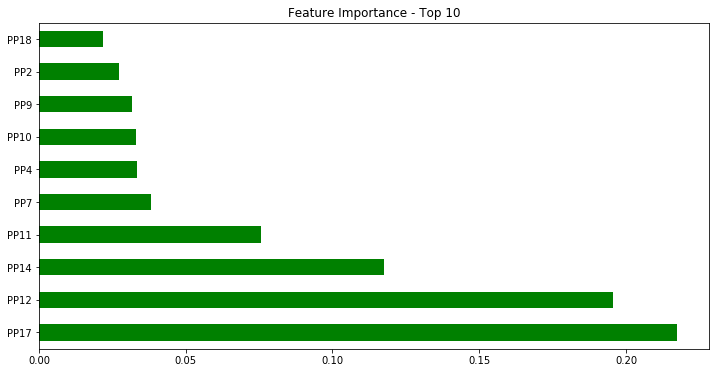

In [32]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                index = features,
                                    columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(12,6))
feature_importances.importance[:10].plot(kind='barh', color='green')
plt.title('Feature Importance - Top 10')

plt.show()

We can see that 4 features are predominant (PP17, PP12, PP14 and PP11). Not coincidentally, those features are among the ones with the highest correlation to the target (review correlations heatmap if necessary). The model makes sense.

In [33]:
feature_importances.iloc[0:4].sum()

importance    0.605623
dtype: float64

Those 4 variables are responsible for 60% of the splits.

In [34]:
feature_importances.iloc[-5:]

,importance
PP8,0.010476
PP20,0.010262
PP15,0.009730
Sacado,0.009017
PP24,0.002828


PP24 has the lowest importance, it's the third variable with the highest variance, has 0 correlation with the target and 0 fraud frequency in its outliers. Hence, it is most probably just noise confusing our algorithms. Will drop this column. 

#### Drop PP24 and check if RF does slightly better

In [35]:
df_new = df_scaled.copy()

df_new.drop(['PP24'], axis=1, inplace=True)
features = [col for col in df_new if col != 'Fraude']

X = df_new[features].values 
y = df_new['Fraude'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=10, random_state=42)  
rf.fit(X_train, y_train)  

y_pred_test = rf.predict(X_test)

model_metrics(y_test, y_pred_test)

Confusion Matrix: 
 [[44925     4]
 [   24    47]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     44929
           1       0.92      0.66      0.77        71

   micro avg       1.00      1.00      1.00     45000
   macro avg       0.96      0.83      0.89     45000
weighted avg       1.00      1.00      1.00     45000

Accuracy:  0.9993777777777778
AUC:  0.8309414008142425
KS:  0.6618828016284849


Well, it just made one more fraudster being incorrectly classified as clean. Small change, but for the worst. Will keep variable PP24.

### Try Naive Bayes

In [36]:
nb = GaussianNB() 
nb.fit(X_train, y_train)  

y_pred_train = nb.predict(X_train)
y_pred_test = nb.predict(X_test)

print("Gaussian NB trained!\n")

Gaussian NB trained!



In [37]:
model_metrics(y_train, y_pred_train)

Confusion Matrix: 
 [[102971   1863]
 [    33    133]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    104834
           1       0.07      0.80      0.12       166

   micro avg       0.98      0.98      0.98    105000
   macro avg       0.53      0.89      0.56    105000
weighted avg       1.00      0.98      0.99    105000

Accuracy:  0.9819428571428571
AUC:  0.8917169335525515
KS:  0.7834338671051031


In [38]:
model_metrics(y_test, y_pred_test)

Confusion Matrix: 
 [[44103   826]
 [   11    60]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     44929
           1       0.07      0.85      0.13        71

   micro avg       0.98      0.98      0.98     45000
   macro avg       0.53      0.91      0.56     45000
weighted avg       1.00      0.98      0.99     45000

Accuracy:  0.9814
AUC:  0.9133429301128948
KS:  0.8266858602257897


Although NB does not perform as well as RF on the training set, it generalizes much better, and has a much higher Recall (0.85!). The "cost", however, is a huge decrease on Precision (0.07) and consequently on F-1 (0.13). Again, this depends on the objective - since we are focusing on Recall no matter what, NB did better than RF.

### Try Regularized Logistic Regression

In [39]:
lr = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', random_state=42) 
lr.fit(X_train, y_train)  

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print("LR trained!\n")

LR trained!



In [40]:
model_metrics(y_train, y_pred_train)

Confusion Matrix: 
 [[104824     10]
 [    41    125]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    104834
           1       0.93      0.75      0.83       166

   micro avg       1.00      1.00      1.00    105000
   macro avg       0.96      0.88      0.92    105000
weighted avg       1.00      1.00      1.00    105000

Accuracy:  0.9995142857142857
AUC:  0.8764583296461118
KS:  0.7529166592922236


In [41]:
model_metrics(y_test, y_pred_test)

Confusion Matrix: 
 [[44926     3]
 [   23    48]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     44929
           1       0.94      0.68      0.79        71

   micro avg       1.00      1.00      1.00     45000
   macro avg       0.97      0.84      0.89     45000
weighted avg       1.00      1.00      1.00     45000

Accuracy:  0.9994222222222222
AUC:  0.837994783005048
KS:  0.6759895660100961


Logistic Regression generalized better than RF, but had similar results.

### Try Linear SVM

In [42]:
lsvm = LinearSVC(penalty='l2', loss='hinge', C=1.0, max_iter=5000, random_state=42) 
lsvm.fit(X_train, y_train)  

y_pred_train = lsvm.predict(X_train)
y_pred_test = lsvm.predict(X_test)

print("Linear SVM trained!\n")

Linear SVM trained!



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [43]:
model_metrics(y_train, y_pred_train)

Confusion Matrix: 
 [[104815     19]
 [    39    127]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    104834
           1       0.87      0.77      0.81       166

   micro avg       1.00      1.00      1.00    105000
   macro avg       0.93      0.88      0.91    105000
weighted avg       1.00      1.00      1.00    105000

Accuracy:  0.999447619047619
AUC:  0.8824395010264076
KS:  0.7648790020528151


In [44]:
model_metrics(y_test, y_pred_test)

Confusion Matrix: 
 [[44919    10]
 [   20    51]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     44929
           1       0.84      0.72      0.77        71

   micro avg       1.00      1.00      1.00     45000
   macro avg       0.92      0.86      0.89     45000
weighted avg       1.00      1.00      1.00     45000

Accuracy:  0.9993333333333333
AUC:  0.8590436428806765
KS:  0.718087285761353


SVM also generalized better than the Random Forest and had basically the same F1-Score (0.77) - with a better Recall, AUC and KS, and worse Precision. If one wanted F-1 as metric, SVM would be the choice.

### GridSearch CV <a class="anchor" id="9"></a>

Lastly, I will try a GridSearch using 5-fold Cross Validation and optimizing Recall - to see if Naive Bayes can be beaten.

#### Random Forest

In [301]:
rf_parameters = {
    'n_estimators': [10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 5, 10, 50, 200],
    'min_samples_leaf': [5, 10, 50]
    }

gsrf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=rf_parameters, cv=5, 
                    scoring='recall')

gsrf.fit(X_train, y_train)

print("Best score: %0.3f" % gsrf.best_score_)
print("Best parameters set:")
best_parameters = gsrf.best_estimator_.get_params()
for param_name in sorted(rf_parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.735
Best parameters set:
	criterion: 'entropy'
	max_depth: 10
	min_samples_leaf: 5
	n_estimators: 100


About 7 points of increase, but still far from NB.

#### Logistic Regression

In [303]:
lr_parameters = {
    'penalty': ['l1', 'l2'],
    'C': [100, 10, 1, 0.1, 0.01]
    }

gslr = GridSearchCV(LogisticRegression(random_state=42), param_grid=lr_parameters, cv=5, 
                    scoring='recall')

gslr.fit(X_train, y_train)

print("Best score: %0.3f" % gslr.best_score_)
print("Best parameters set:")
best_parameters = gslr.best_estimator_.get_params()
for param_name in sorted(lr_parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best score: 0.729
Best parameters set:
	C: 100
	penalty: 'l1'


Once again, very similar to Random Forest.

#### RBF SVM

In [50]:
svm_parameters = {
    'gamma': [1, 0.1, 0.01],
    'C': [100, 10, 1, 0.01]
    }

gssvm = GridSearchCV(SVC(random_state=42, kernel='rbf'), param_grid=svm_parameters, cv=5, 
                    scoring='recall')

gssvm.fit(X_train, y_train)

print("Best score: %0.3f" % gssvm.best_score_)
print("Best parameters set:")
best_parameters = gssvm.best_estimator_.get_params()
for param_name in sorted(svm_parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.717
Best parameters set:
	C: 1
	gamma: 0.01


#### Linear SVM

In [54]:
svm_parameters = {
    'C': [1000, 100, 10, 1, 0.01]
    }

gssvm = GridSearchCV(LinearSVC(random_state=42), param_grid=svm_parameters, cv=2, 
                    scoring='recall')

gssvm.fit(X_train, y_train)

print("Best score: %0.3f" % gssvm.best_score_)
print("Best parameters set:")
best_parameters = gssvm.best_estimator_.get_params()
for param_name in sorted(svm_parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best score: 0.753
Best parameters set:
	C: 100


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Conclusion <a class="anchor" id="10"></a>

We started with a dataset of 150k records and 30 features, containing an unbalanced (0.16%) amount of fraudsters and no null values. Most of the features were normally distributed and had very little correlation. Outliers (|Z-score| > 3) with no fraudster frequency were imputed with the mean, variables with low variance (PCA was also tried but deemed not useful, as too little variance was kept in low dimension spaces) were removed and then scaled.

For modeling, a stratified 70/30 split was adopted and Recall was the most important metric observed. Out of the models tested (Random Forest, Naive Bayes, Logistic Regression and SVM), NB had the best performance, achieving 0.85 Recall while not overfitting (although its precision and F1-score were much lower than the other algorithms - but we are focusing on Recall solely). While RF was almost perfect on the training set, it severely overfitted and had a Recall of 0.68 (same as LR, that generalized better). Linear SVM had about the same F-1 Score (0.77) as LR and RF, but it has a higher Recall (0.72) and Lower Precision (0.84) - hence, would be prefered if F-1 was the metric chosen. GridSearch did improve some points in Recall, but still about 10 points below NB.

If one wanted to go even further on this analysis, techniques such as Undersampling, Oversampling and Synthetic Sampling (like SMOTE) could be used to avert the imbalance between classes. Even more, the problem could be turned into an Anomaly Detection, using techniques such as Isolation Forest or Local Outlier Factor.